# JaxLayerLumos RAM Design Demo
- Radar-Absorbing Coating Optimization
- Combines random search and gradient-based optimization

In [ ]:
## Install Jaxlayerlumos if you have not
# !pip install jaxlayerlumos jax optax matplotlib

In [88]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from jaxlayerlumos import stackrt_eps_mu, utils_materials
import numpy as onp
from tqdm import tqdm
from datetime import datetime
import random
import time
import pandas as pd
from optax import contrib 

## 1. Configuration & Materials Setup

In [69]:
class RAMConfig:
    def __init__(self, name, freq_range, num_layers):
        self.name = name # Name of Config
        self.freq_range = freq_range  # GHz
        self.num_layers = num_layers
        self.inc_angle = [0.0]  # Normal incidence

# HF-band configuration
HF = RAMConfig(name = "HF", freq_range=(2.0, 8.0), num_layers=5)

In [64]:
# Use materials from JaxLayerLumos' utilities
MATERIALS = [str(i) for i in range(1, 17)] # 17 fictional material
n_materials = len(MATERIALS)

def encode_material(material, materials_list):
    """
    Encode a material string to an integer based on its position in the materials list.
    """
    return materials_list.index(material)

def decode_material(index, materials_list):
    """
    Decode an integer back to its corresponding material string.
    """
    return materials_list[int(index)]

## 2. Core Simulation Functions

In [53]:
def get_max_reflection(freq_ghz, R_db, freq_range):
    """
    Compute the maximum reflection and its corresponding frequency within a specified range.
    
    Parameters:
    - freq_ghz: Array of frequencies in GHz.
    - R_db: Reflectance in dB.
    - freq_range: Tuple specifying the (min_freq, max_freq) in GHz.
    
    Returns:
    - r_max: Maximum reflectance in dB within the frequency range.
    - f_max: Frequency at which the maximum reflectance occurs.
    """
    mask = (freq_ghz >= freq_range[0]) & (freq_ghz <= freq_range[1])
    if not jnp.any(mask):
        return -jnp.inf, 0.0  # If no frequencies are within the range
    R_filtered = R_db[mask]
    freq_filtered = freq_ghz[mask]
    r_max = jnp.max(R_filtered)
    f_max = freq_filtered[jnp.argmax(R_filtered)]
    return r_max, f_max

def objective_function(X, n_layers, config, num_freq_points=1000):
    """
    Evaluate the objective functions based on the given design variables.
    
    Parameters:
    - X: A 1D array where the first n_layers elements are material indices and the next n_layers elements are thicknesses.
    - n_layers: Number of layers.
    - config: OptimizationConfig object containing freq_range and inc_angle.
    - num_freq_points: Number of frequency points for simulation.
    
    Returns:
    - A tuple containing the two objective values (rmax, sum_thicknesses).
    """
    # Split X into materials and thicknesses
    layer_materials_encoded = X[:n_layers]
    layer_materials = ['Air'] + [decode_material(index, MATERIALS) for index in layer_materials_encoded] + ['PEC']
    layer_thicknesses = jnp.array([0.0] + list(X[n_layers:]) + [0.0])
    
    # Convert freq_range from GHz to Hz and generate frequency array
    freq_start_hz = config.freq_range[0] * 1e9
    freq_end_hz = config.freq_range[1] * 1e9
    frequencies = jnp.linspace(freq_start_hz, freq_end_hz, num_freq_points)
    freq_ghz = frequencies / 1e9  # Convert back to GHz for get_max_reflection
    
    # Get permittivity and permeability
    eps_stack, mu_stack = utils_materials.get_eps_mu(layer_materials, frequencies)
    
    # Compute reflection for all incidence angles
    max_R_db = -jnp.inf
    for angle in config.inc_angle:
        R_TE, T_TE, R_TM, T_TM = stackrt_eps_mu(
            eps_stack, mu_stack, layer_thicknesses, frequencies, angle
        )
        R_linear = (R_TM + R_TE) / 2

        R_db = 10 * jnp.log10(R_linear).squeeze()
        r_max, _ = get_max_reflection(freq_ghz, R_db, config.freq_range)
        max_R_db = jnp.maximum(max_R_db, r_max)
    
    # Sum of thicknesses
    sum_thicknesses = jnp.sum(layer_thicknesses[1:-1])
    
    return -max_R_db, sum_thicknesses

## 3. Optimization Workflow

### 3.1 Random Search

In [84]:
def get_max_reflection(freq_ghz, R_db, freq_range):
    """
    Compute the maximum reflection and its corresponding frequency within a specified range.
    
    Parameters:
    - freq_ghz: Array of frequencies in GHz.
    - R_db: Reflectance in dB.
    - freq_range: Tuple specifying the (min_freq, max_freq) in GHz.
    
    Returns:
    - r_max: Maximum reflectance in dB within the frequency range.
    - f_max: Frequency at which the maximum reflectance occurs.
    """
    mask = (freq_ghz >= freq_range[0]) & (freq_ghz <= freq_range[1])
    if not jnp.any(mask):
        return -jnp.inf, 0.0  # If no frequencies are within the range
    R_filtered = R_db[mask]
    freq_filtered = freq_ghz[mask]
    r_max = jnp.max(R_filtered)
    f_max = freq_filtered[jnp.argmax(R_filtered)]
    return r_max, f_max

def objective_function(X, n_layers, config, num_freq_points=1000):
    """
    Evaluate the objective functions based on the given design variables.
    
    Parameters:
    - X: A 1D array where the first n_layers elements are material indices and the next n_layers elements are thicknesses.
    - n_layers: Number of layers.
    - config: OptimizationConfig object containing freq_range and inc_angle.
    - num_freq_points: Number of frequency points for simulation.
    
    Returns:
    - A tuple containing the two objective values (rmax, sum_thicknesses).
    """
    # Split X into materials and thicknesses
    layer_materials_encoded = X[:n_layers]
    layer_materials = ['Air'] + [decode_material(index, MATERIALS) for index in layer_materials_encoded] + ['PEC']
    layer_thicknesses = jnp.array([0.0] + list(X[n_layers:]) + [0.0])
    
    # Convert freq_range from GHz to Hz and generate frequency array
    freq_start_hz = config.freq_range[0] * 1e9
    freq_end_hz = config.freq_range[1] * 1e9
    frequencies = jnp.linspace(freq_start_hz, freq_end_hz, num_freq_points)
    freq_ghz = frequencies / 1e9  # Convert back to GHz for get_max_reflection
    
    # Get permittivity and permeability
    eps_stack, mu_stack = utils_materials.get_eps_mu(layer_materials, frequencies)
    
    # Compute reflection for all incidence angles
    max_R_db = -jnp.inf
    for angle in config.inc_angle:
        R_TE, T_TE, R_TM, T_TM = stackrt_eps_mu(
            eps_stack, mu_stack, layer_thicknesses, frequencies, angle
        )
        R_linear = (R_TM + R_TE) / 2

        R_db = 10 * jnp.log10(R_linear).squeeze()
        r_max, _ = get_max_reflection(freq_ghz, R_db, config.freq_range)
        max_R_db = jnp.maximum(max_R_db, r_max)
    
    # Sum of thicknesses
    sum_thicknesses = jnp.sum(layer_thicknesses[1:-1])
    
    return -max_R_db, sum_thicknesses

def identify_pareto(scores):
    """
    Identify Pareto front from a set of objective scores.
    
    Parameters:
    - scores: A NumPy array of shape (n_points, n_objectives).
    
    Returns:
    - Indices of points that are on the Pareto front.
    """
    population_size = scores.shape[0]
    population_ids = np.arange(population_size)
    pareto_front = np.ones(population_size, dtype=bool)
    
    for i in range(population_size):
        for j in range(population_size):
            # Assuming maximization for rmax and minimization for sum_thicknesses
            # Adjust the condition based on your objectives
            # Here, we consider rmax to be maximized and sum_thicknesses to be minimized
            if (scores[j][0] >= scores[i][0] and scores[j][1] <= scores[i][1]) and \
               (scores[j][0] > scores[i][0] or scores[j][1] < scores[i][1]):
                pareto_front[i] = False
                break
    return population_ids[pareto_front]

def random_search(config, total_evaluations=5000):
    """
    Perform Random Search optimization with timing and logging.
    
    Parameters:
    - num_layers: Number of layers in the design.
    - config: OptimizationConfig object containing freq_range and inc_angle.
    - total_evaluations: Total number of evaluations to perform.
    """
    start_time = time.time()  # Start timing

    n_layers = config.num_layers
    num_layers = config.num_layers
    today_date = datetime.now().strftime("%Y-%m-%d")
    evaluations = 0

    # Lists to store results
    all_train_x = []
    all_train_obj = []

    # Define bounds for thicknesses based on configuration
    thickness_min, thickness_max = (15e-6, 2000e-6)  # Updated bounds

    # Generate initial random data (e.g., 10 samples)
    initial_samples = 10
    for _ in range(initial_samples):
        # Randomly select materials
        cat_samples = [random.randint(0, n_materials - 1) for _ in range(n_layers)]
        # Randomly select thicknesses within bounds
        cont_samples = [random.uniform(thickness_min, thickness_max) for _ in range(n_layers)]
        # Combine categorical and continuous samples
        sample = cat_samples + cont_samples
        all_train_x.append(sample)
        # Evaluate objective function
        obj = objective_function(sample, n_layers, config)
        all_train_obj.append(obj)
        evaluations += 1

    # Perform random sampling for the remaining evaluations with progress bar
    with tqdm(total=total_evaluations, desc="Random Search Progress", unit="eval", leave=True) as pbar:
        while evaluations < total_evaluations:
            # Randomly select materials
            cat_samples = [random.randint(0, n_materials - 1) for _ in range(n_layers)]
            # Randomly select thicknesses within bounds
            cont_samples = [random.uniform(thickness_min, thickness_max) for _ in range(n_layers)]
            # Combine categorical and continuous samples
            sample = cat_samples + cont_samples
            all_train_x.append(sample)
            # Evaluate objective function
            obj = objective_function(sample, n_layers, config)
            all_train_obj.append(obj)
            evaluations += 1
            pbar.update(1)  # Update the progress bar
            
            # Log iteration count every 100 evaluations
            if evaluations % 100 == 0:
                print(f"Iteration {evaluations}/{total_evaluations} completed.")

    # End timing
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Random Search completed in {elapsed_time:.2f} seconds.")

    # Convert to NumPy arrays for processing
    train_x = onp.array(all_train_x)
    train_obj = onp.array(all_train_obj)

    # Identify Pareto front
    pareto_indices = identify_pareto(train_obj)
    pareto_parameters = train_x[pareto_indices]
    pareto_objectives = train_obj[pareto_indices]

    # Decode materials
    decoded_materials = [[decode_material(index, MATERIALS) for index in row[:n_layers]] for row in pareto_parameters]
    thicknesses = pareto_parameters[:, n_layers:].tolist()

    # Plot the Pareto frontier
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(train_obj[:, 1], train_obj[:, 0], c="blue", label="All Points", alpha=0.5)
    ax.scatter(pareto_objectives[:, 1], pareto_objectives[:, 0], c="red", label="Pareto Frontier")
    ax.set_title("Pareto Frontier - Random Search")
    ax.set_ylabel("Objective 1 (r_max [dB])")
    ax.set_xlabel("Objective 2 (Sum of Thicknesses [m])")
    ax.legend()
    ax.grid(True)

    columns = (
        [f'Material{i}' for i in range(1, n_layers+1)] +
        [f'Thickness{i}' for i in range(1, n_layers+1)] +
        ['Objective1 (r_max [dB])', 'Objective2 (Sum Thickness [m])']
    )
    
    data = [
        materials + thickness + objectives.tolist()
        for materials, thickness, objectives in zip(decoded_materials, thicknesses, pareto_objectives)
    ]
    
    pareto_df = pd.DataFrame(data, columns=columns)

    data = []
    for i in range(train_x.shape[0]):
        materials = [decode_material(index, MATERIALS) for index in train_x[i, :n_layers]]
        thicknesses = train_x[i, n_layers:].tolist()
        objectives = train_obj[i].tolist()
        data.append(materials + thicknesses + objectives)
    
    full_df = pd.DataFrame(data, columns=columns)
    return {
        'pareto_frontier': pareto_df,
        'all_data': full_df,
        'figure': fig,
        'train_x': train_x,
        'train_obj': train_obj
    }


Random Search Progress:   0%|          | 0/10 [00:00<?, ?eval/s]

Random Search completed in 0.74 seconds.
Random Search completed for 5 layers using configuration 'HF'. Results saved in 'res/RANDOM/2025-01-24/5layers/HF/'


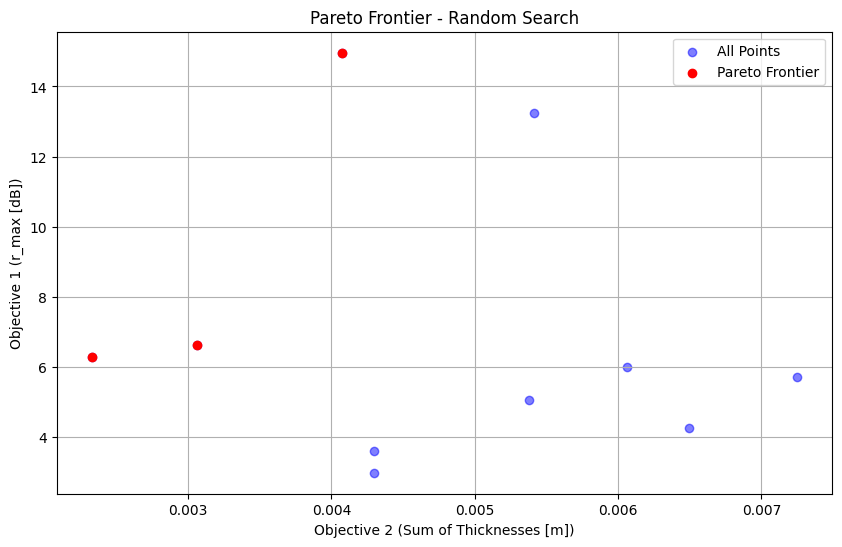

In [85]:
result= random_search(config = HF, total_evaluations=10)

In [127]:
pareto_df = result["pareto_frontier"]
pareto_df

,Material1,Material2,Material3,Material4,Material5,Thickness1,Thickness2,Thickness3,Thickness4,Thickness5,Objective1 (r_max [dB]),Objective2 (Sum Thickness [m])
0,16,1,12,5,16,0.000662,0.001671,0.001339,0.000204,0.000195,14.960318,0.004072
1,6,13,3,13,9,0.000453,0.000323,0.000748,0.000170,0.000638,6.270433,0.002332
2,7,3,13,6,2,0.000394,0.001007,0.000256,0.001275,0.000134,6.624141,0.003066


In [132]:
def plot_reflection_spectrum(internal_materials, internal_thicknesses, config):
    """
    Plot reflection spectrum for a given material stack configuration.
    
    Parameters:
    - internal_materials: List of material names for internal layers (excluding boundaries)
    - internal_thicknesses: JAX array of thickness values for internal layers (in meters)
    - config: OptimizationConfig object with frequency range and incidence angles
    """
    # Construct full layer stack with boundary layers
    layer_materials = ['Air'] + internal_materials + ['PEC']
    
    # Convert all thickness components to JAX arrays before concatenation
    boundary_start = jnp.array([0.0])
    boundary_end = jnp.array([0.0])
    layer_thicknesses = jnp.concatenate([
        boundary_start,
        internal_thicknesses,
        boundary_end
    ])
    
    # Generate frequency array
    freq_min, freq_max = config.freq_range
    frequencies = jnp.linspace(freq_min * 1e9, freq_max * 1e9, 1000)
    freq_ghz = frequencies / 1e9
    
    # Get material properties
    eps_stack, mu_stack = utils_materials.get_eps_mu(layer_materials, frequencies)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Calculate reflection for each incidence angle
    for angle in config.inc_angle:
        R_TE, T_TE, R_TM, T_TM = stackrt_eps_mu(
            eps_stack, mu_stack, layer_thicknesses, frequencies, angle
        )
        R_avg = (R_TE + R_TM) / 2
        R_db = 10 * jnp.log10(R_avg).squeeze()
        
        plt.plot(freq_ghz, R_db, label=f'{angle}° Incidence')
    
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Reflection Coefficient (dB)")
    plt.title("Frequency Response of Optimized Structure")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_layer_structure(internal_materials, internal_thicknesses):
    """
    Visualize the material stack with layer thicknesses.
    
    Parameters:
    - internal_materials: List of material names for internal layers
    - internal_thicknesses: List of thickness values in meters
    - save_path: Optional path to save the figure
    """
    # Add boundary layers with zero thickness
    full_materials = ['Air'] + internal_materials + ['PEC']
    full_thicknesses = [0.0] + internal_thicknesses + [0.0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = 0
    
    # Plot each layer with material-specific coloring
    for material, thickness in zip(full_materials, full_thicknesses):
        if thickness <= 0:
            continue  # Skip boundary layers
            
        color = MATERIALS_COLORS.get(material, 'grey')
        ax.barh(bottom, 1, height=thickness, left=0, color=color)
        
        # Annotate with material and thickness
        label = f"{material}\n{thickness*1e6:.1f} μm"
        ax.text(0.5, bottom + thickness/2, label,
                ha='center', va='center', color='white', fontsize=12)
        
        bottom += thickness
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, bottom)
    ax.axis('off')
    plt.title("Optimized Layer Structure")
    plt.show()

In [136]:
## Inspect a structure and its spectrum
s1 = pareto_df.iloc[0]  # <-- Use iloc instead of ix
plot_reflection_spectrum(s1[:HF.num_layers], jnp.array(s1[HF.num_layers: 2*HF.num_layers],dtype=jnp.float32), HF)

AssertionError: 

### 3.2 Gradient Based Optimization

In [102]:
def objective(
    thicknesses,
    material_layout,
    frequencies,
    inc_angles,
    freq_range,
    materials_list,
    weight_rmax,
    weight_thickness
):
    """
    Simplified Objective function for optimization.
    
    Parameters:
    - thicknesses: JAX array of thicknesses (including boundary layers).
    - material_layout: list of material indices (integers).
    - frequencies: Array of frequencies for simulation (in Hz).
    - inc_angles: List of incidence angles in degrees.
    - freq_range: Tuple specifying the (min_freq, max_freq) in GHz for r_max calculation.
    - materials_list: List of material strings.
    - weight_rmax: Weight parameter for r_max.
    - weight_thickness: Weight parameter for sum of thicknesses.
    
    Returns:
    - combined_obj: Scalar value representing the combined objective.
    - individual_objs: Tuple of individual objectives (r_max, sum_thicknesses).
    """
    # Extract internal thicknesses
    internal_thicknesses = thicknesses[1:-1]
    
    # Decode material stack
    layer_materials = ['Air'] + [decode_material(index, materials_list) for index in material_layout] + ['PEC']
    
    # Get permittivity and permeability
    eps_stack, mu_stack = utils_materials.get_eps_mu(layer_materials, frequencies)
    
    # Compute reflection for all incidence angles
    max_R_db = -jnp.inf
    for angle in inc_angles:
        # Remove print statements to ensure compatibility with JAX tracing
        R_TE, T_TE, R_TM, T_TM = stackrt_eps_mu(
            eps_stack, mu_stack, thicknesses, frequencies, angle
        )
        R_linear = (R_TM + R_TE) / 2
        
        # **Safeguard: Prevent R_linear from being non-positive**
        epsilon = 1e-12  # Small constant to prevent log10(0)
        R_linear_safe = jnp.maximum(R_linear, epsilon)
        
        R_db = 10 * jnp.log10(R_linear_safe).squeeze()
        r_max, _ = get_max_reflection(frequencies / 1e9, R_db, freq_range)
        max_R_db = jnp.maximum(max_R_db, r_max)
    
    # Sum of thicknesses
    sum_thicknesses = jnp.sum(internal_thicknesses)
    
    # Combined objective: maximize r_max and minimize sum_thicknesses
    combined_obj = weight_rmax * max_R_db + weight_thickness * sum_thicknesses  # Adjusted with weights
    
    # **Optional: Penalize Invalid Objectives**
    # combined_obj = jnp.where(jnp.isnan(combined_obj), 1e6, combined_obj)
    
    individual_objs = (-max_R_db, sum_thicknesses)
    
    return combined_obj, individual_objs

def optimize_thicknesses_optax(
    material_layout, 
    initial_thicknesses_with_boundaries, 
    bounds, 
    frequencies,
    inc_angles,
    polarization,
    prefix,
    freq_range,
    materials_list,
    weight_rmax,
    weight_thickness,
    max_iters=20, 
    tol=1e-6
):
    """
    Optimize thicknesses for a given material layout using Optax's DoG optimizer and record trajectory.
    
    Parameters:
    - material_layout: list of material indices (integers).
    - initial_thicknesses_with_boundaries: initial thicknesses with boundary layers (including zeros).
    - bounds: list of tuples specifying (min, max) for each internal layer.
    - frequencies: Array of frequencies for simulation (in Hz).
    - inc_angles: List of incidence angles in degrees.
    - polarization: Polarization type ('te', 'tm', 'both').
    - prefix: Prefix string for labeling.
    - freq_range: Tuple specifying the (min_freq, max_freq) in GHz for r_max calculation.
    - materials_list: List of material strings.
    - weight_rmax: Weight parameter for r_max.
    - weight_thickness: Weight parameter for sum of thicknesses.
    - max_iters: maximum number of iterations.
    - tol: tolerance for convergence based on gradient norm or objective change.
    
    Returns:
    - optimized_thicknesses: NumPy array of optimized thicknesses (internal layers only).
    - objectives: list of objective values [rmax, sum_thicknesses].
    - trajectory_evaluations: list of tuples (params, objectives) for each iteration.
    """
    # Initialize parameters as JAX array (including boundary layers)
    params = jnp.array(initial_thicknesses_with_boundaries)
    
    # Create a mask: False for boundary layers, True for internal layers
    mask = jnp.array([False] + [True] * (len(params) - 2) + [False])
    
    # Initialize the DoG optimizer with the mask and adjusted learning rate
    optimizer = contrib.dog(
        learning_rate=0.1,        # **Reduced learning rate for stability**
        reps_rel=1e-5,             # Relative step size for Reparameterization
        eps=1e-8,                  # Epsilon for numerical stability
        weight_decay=None,         # Set to a float if weight decay is desired
        mask=mask                  # Mask to fix boundary layers
    )
    opt_state = optimizer.init(params)

    # Initialize trajectory evaluations list for this run
    trajectory_evaluations = []
    
    # Extract lower and upper bounds for internal layers
    lower_bounds = jnp.array([b[0] for b in bounds])
    upper_bounds = jnp.array([b[1] for b in bounds])
    
    # Initialize variables for early stopping based on objective change
    prev_obj = None
    for step in range(max_iters):
        # Compute objective
        scalar_obj, individual_objs = objective(
            params, 
            material_layout, 
            frequencies, 
            inc_angles, 
            freq_range, 
            materials_list, 
            weight_rmax, 
            weight_thickness
        )
        
        # Append to trajectory evaluations
        trajectory_evaluations.append((onp.array(params), individual_objs))
        
        # **Logging the Objectives**
        print(f"Iteration {step+1}: r_max={individual_objs[0]:.4f} dB, Sum Thickness={individual_objs[1]:.4e} m")
        
        # Compute gradients using the scalar objective
        gradient = jax.grad(lambda x: objective(x, material_layout, frequencies, inc_angles, freq_range, materials_list, weight_rmax, weight_thickness)[0])(params)
        
        # **Manual Gradient Masking**
        gradient = jnp.where(mask, gradient, 0.0)
        # print("grad :", gradient)
        
        # **Check for NaNs in gradients**
        if jnp.any(jnp.isnan(gradient)):
            print(f"[Error] NaN detected in gradients at iteration {step+1}. Stopping optimization.")
            break
        
        # Compute updates using the optimizer with masked gradients
        updates, opt_state = optimizer.update(gradient, opt_state, params)
        
        # Apply updates
        params = optax.apply_updates(params, updates)
        # print("params : ", params)
        
        # **Enforce boundary layers to remain zero**
        params = params.at[0].set(0.0)
        params = params.at[-1].set(0.0)
        
        # **Enforce bounds on internal layers**
        internal_layers = params[1:-1]
        clamped_internal = jnp.clip(internal_layers, lower_bounds, upper_bounds)
        params = jnp.concatenate([params[:1], clamped_internal, params[-1:]])
        
        # Compute gradient norm for convergence
        grad_norm = jnp.linalg.norm(gradient * mask).item()
        
        # Compute objective change for early stopping
        current_obj = scalar_obj.item()
        if prev_obj is not None:
            obj_change = abs(current_obj - prev_obj)
            if obj_change < tol:
                print(f"Early stopping at step {step+1} with objective change {obj_change:.4e} < tol={tol}")
                break
        prev_obj = current_obj
        
        if grad_norm < tol:
            print(f"Converged at step {step+1} with gradient norm {grad_norm:.4e}")
            break
        
        # Print progress every 100 steps and the first 5 steps for short iterations
        if (step+1) % 100 == 0 or step < 5:
            print(f"Step {step+1}: Combined Objective = {current_obj:.4f}, Gradient Norm = {grad_norm:.4e}")
    
    # After optimization, compute final objectives
    final_scalar_obj, final_individual_objs = objective(
        params, 
        material_layout, 
        frequencies, 
        inc_angles, 
        freq_range, 
        materials_list, 
        weight_rmax, 
        weight_thickness
    )
    objectives = list(final_individual_objs)
    
    # Extract only the internal thicknesses (exclude boundaries)
    optimized_thicknesses = onp.array(params[1:-1])
    
    return optimized_thicknesses, objectives, trajectory_evaluations

In [123]:
def two_level_optimization(
    num_layers, 
    initial_dataframe,  # DataFrame from random_search's 'all_data'
    weight_rmax,          
    weight_thickness,    
    total_evaluations=5, 
    max_iters=20, 
    tol=1e-6,
    config=None  
):
    """
    Perform two-level optimization using initial points from a DataFrame.
    
    Parameters:
    - num_layers: Number of internal layers.
    - initial_dataframe: DataFrame with columns Material1..N, Thickness1..N, etc.
    - weight_rmax: Weight for r_max objective.
    - weight_thickness: Weight for thickness objective.
    - total_evaluations: Max evaluations (None for all rows).
    - max_iters: Optimizer iterations per layout.
    - tol: Convergence tolerance.
    - config: OptimizationConfig with freq_range, inc_angle, etc.
    
    Returns:
    - Dictionary with Pareto frontier, all data, trajectories, and figure.
    """
    # Process DataFrame to create initial_points
    initial_points = []
    material_cols = [f'Material{i}' for i in range(1, num_layers+1)]
    thickness_cols = [f'Thickness{i}' for i in range(1, num_layers+1)]
    
    for _, row in initial_dataframe.iterrows():
        try:
            # Encode materials to indices
            material_layout = [encode_material(row[col], MATERIALS) for col in material_cols]
            # Extract thicknesses and add boundaries
            thicknesses = [float(row[col]) for col in thickness_cols]
            thicknesses_with_boundaries = [0.0] + thicknesses + [0.0]
            initial_points.append((material_layout, thicknesses_with_boundaries))
        except (ValueError, KeyError) as e:
            print(f"Skipping row due to error: {e}")
            continue
    
    # Limit evaluations if specified
    if total_evaluations is not None:
        initial_points = initial_points[:total_evaluations]
    
    # Optimization setup
    bounds = [(15e-6, 1500e-6) for _ in range(num_layers)]
    freq_min, freq_max = config.freq_range
    frequencies = jnp.linspace(freq_min * 1e9, freq_max * 1e9, 1000)
    inc_angles = config.inc_angle
    polarization = "both"
    prefix = "Layer"
    
    # Track results
    all_train_materials = []
    all_train_thicknesses = []
    all_train_obj = []
    all_trajectories = []  # Each entry is a list of (params, objectives)
    
    # Optimize each initial point
    for i, (material_layout, initial_thickness) in enumerate(initial_points):
        optimized_thickness, objectives, trajectory = optimize_thicknesses_optax(
            material_layout, initial_thickness, bounds, frequencies,
            inc_angles, polarization, prefix, config.freq_range,
            MATERIALS, weight_rmax, weight_thickness, max_iters, tol
        )
        
        all_train_materials.append(material_layout)
        all_train_thicknesses.append(optimized_thickness)
        all_train_obj.append(objectives)
        all_trajectories.append(trajectory)
        print(f"Optimized layout {i+1}/{len(initial_points)}")
    
    # Convert to arrays
    train_materials = onp.array(all_train_materials)
    train_thicknesses = onp.array(all_train_thicknesses)
    train_obj = onp.array(all_train_obj)
    
    # Identify Pareto front
    pareto_indices = identify_pareto(train_obj)
    pareto_materials = train_materials[pareto_indices]
    pareto_thicknesses = train_thicknesses[pareto_indices]
    pareto_objectives = train_obj[pareto_indices]
    
    # Build DataFrames
    def build_dataframe(materials, thicknesses, objectives):
        data = []
        for mat_row, thick_row, obj_row in zip(materials, thicknesses, objectives):
            decoded_mats = [decode_material(idx, MATERIALS) for idx in mat_row]
            internal_thick = thick_row.tolist()  # Exclude boundary layers
            obj1 = float(obj_row[0])  # First objective (r_max)
            obj2 = float(obj_row[1])  # Second objective (sum thickness)
            data.append(decoded_mats + internal_thick + [obj1, obj2])
        
        columns = (
            [f'Material{i}' for i in range(1, num_layers+1)] +
            [f'Thickness{i}' for i in range(1, num_layers+1)] +
            ['Objective1 (r_max [dB])', 'Objective2 (Sum Thickness [m])']
        )
        return pd.DataFrame(data, columns=columns)
    
    # All data
    all_data_df = build_dataframe(all_train_materials, all_train_thicknesses, all_train_obj)
    
    # Pareto frontier
    pareto_df = build_dataframe(pareto_materials, pareto_thicknesses, pareto_objectives)
    
    # Trajectories DataFrame
    trajectories_data = []
    for traj_id, trajectory in enumerate(all_trajectories, 1):
        for iter_step, (params, obj) in enumerate(trajectory, 1):
            internal_thick = params[1:-1].tolist()  # <-- ADD .tolist()
            obj1 = float(obj[0])
            obj2 = float(obj[1])
            
            row = [traj_id, iter_step] + internal_thick + [obj1, obj2]
            trajectories_data.append(row)
    
    trajectory_columns = (
        ['Trajectory_ID', 'Iteration'] +
        [f'Thickness{i}' for i in range(1, num_layers+1)] +
        ['Objective1 (r_max [dB])', 'Objective2 (Sum Thickness [m])']
    )
    trajectories_df = pd.DataFrame(trajectories_data, columns=trajectory_columns)
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap("tab20")
    
    # Plot trajectories
    for idx, trajectory in enumerate(all_trajectories):
        if not trajectory:
            continue
        rmax = [step[1][0] for step in trajectory]
        thickness = [step[1][1] for step in trajectory]
        plt.plot(thickness, rmax, marker='o', color=cmap(idx % 20), alpha=0.7, linewidth=1)
    
    plt.title("Pareto Frontier with Optimization Trajectories")
    plt.xlabel("Sum of Thicknesses [m]")
    plt.ylabel("r_max [dB]")
    plt.grid(True)
    
    return {
        'pareto_frontier': pareto_df,
        'all_data': all_data_df,
        'trajectories': trajectories_df,
        'figure': fig
    }


Iteration 1: r_max=14.9603 dB, Sum Thickness=4.0720e-03 m
Step 1: Combined Objective = -14.9562, Gradient Norm = 3.6612e+04
Iteration 2: r_max=15.1640 dB, Sum Thickness=3.8997e-03 m
Step 2: Combined Objective = -15.1601, Gradient Norm = 3.6058e+04
Iteration 3: r_max=15.2943 dB, Sum Thickness=3.8896e-03 m
Step 3: Combined Objective = -15.2904, Gradient Norm = 4.1014e+04
Iteration 4: r_max=15.7022 dB, Sum Thickness=3.9053e-03 m
Step 4: Combined Objective = -15.6983, Gradient Norm = 3.9343e+04
Iteration 5: r_max=15.8291 dB, Sum Thickness=3.8977e-03 m
Step 5: Combined Objective = -15.8252, Gradient Norm = 4.4332e+04
Iteration 6: r_max=16.1366 dB, Sum Thickness=3.9102e-03 m
Iteration 7: r_max=16.2972 dB, Sum Thickness=3.9038e-03 m
Iteration 8: r_max=16.5306 dB, Sum Thickness=3.9147e-03 m
Iteration 9: r_max=16.7374 dB, Sum Thickness=3.9089e-03 m
Iteration 10: r_max=16.9059 dB, Sum Thickness=3.9189e-03 m
Iteration 11: r_max=17.1671 dB, Sum Thickness=3.9135e-03 m
Iteration 12: r_max=17.2736 dB

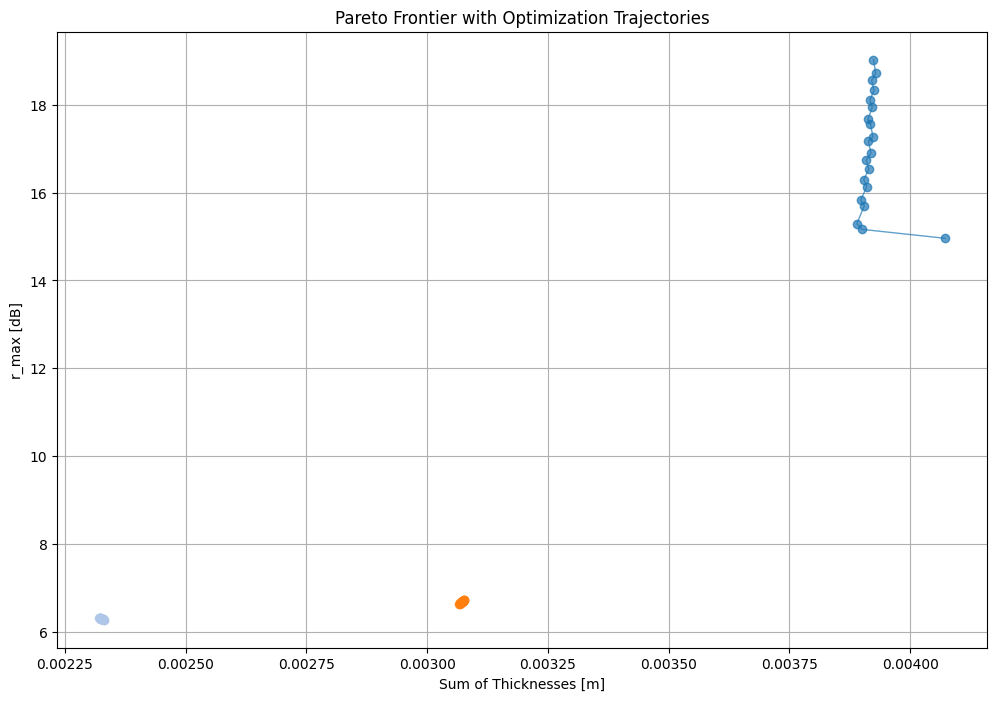

In [124]:
result_two_level = two_level_optimization(
    num_layers=HF.num_layers,
    initial_dataframe=result["pareto_frontier"],
    weight_rmax=1,
    weight_thickness=1,
    config=HF
)